# Benchmark

In this Jupyter notebook, our primary objective is to thoroughly benchmark and compare the performance of our quantum annealing-based optimization problem with that of a classical implementation. This benchmarking process will provide us with valuable insights into the efficiency and effectiveness of the quantum algorithm in solving our specific problem.

Goals of Benchmarking:

**1. Cost Comparison and Visualization:** we will plot and analyse the operational cost or objective function values obtained from both the quantum annealing and classical implementations to assess whether the quantum approach is providing improvements over classical methods.

**2. Relative error:** calculate the relative error for the decision variales against classical methods.

**3. Computational time:** time taken for the CPU and QPU to arrive at optimal solution. In the case of the QPU, we will only consider the annealing time. For further reference, check [this site](https://docs.dwavesys.com/docs/latest/c_qpu_timing.html).

**4.Scalability Testing:** by gradually increasing the size of the optimization problem (e.g., the number of generators or time periods), we will gain insights into the algorithm's efficiency as problem complexity grows.

**5.Impact of Problem Parameters:** Explore the impact of varying problem parameters (such as constraints or costs) on the performance of both the quantum and classical implementations. Specifically, we will analyse the addition of start and shut constraints to the problem. This analysis can uncover scenarios where one approach outperforms the other and guide us in selecting the most suitable algorithm for specific problem instances.

### 1. Import all modules

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pulp import *

from dwave.system import LeapHybridCQMSampler
from dimod import QuadraticModel, ConstrainedQuadraticModel, Binary, Integer

notebook_path = str(os.getcwd()).replace('tests', '')
sys.path.append(notebook_path)
from hybrid_annealing_classical import annealing_classical_method
from classical_method import classical_implementation

# Replace with your DWave token
os.environ['DWAVE_API_TOKEN'] = ''

### 2. Import data

In [49]:
demand = pd.read_csv(notebook_path + 'data/Demand.csv')
fuel_data = pd.read_csv(notebook_path + 'data/Fuels_data.csv')
generators = pd.read_csv(notebook_path + 'data/Generators_data.csv')
generators_variability = pd.read_csv(notebook_path + 'data/Generators_variability.csv')

In [50]:
# Merge the two DataFrames based on the 'Fuel' column
generators = pd.merge(generators, fuel_data, on='Fuel', how='left')

# remove generators with no capacity
generators = generators[generators['Existing_Cap_MW'] > 0]

# Define the resource types to classify
resource_types = ['onshore_wind_turbine', 'small_hydroelectric', 'solar_photovoltaic']

# Create a new column 'IsClassified' based on whether it's varying or non varying generator
generators['IsVariable'] = np.where(generators['Resource'].isin(resource_types), True, False)

# Restructure variability dataframe
variability = generators_variability.melt(id_vars=['Hour'], var_name='generator', value_name='Variability')

# Extract generator type from the column names
variability['generator'] = variability['generator'].str.replace('generator_', '')

### 3. Generate results

We'll tackle a range of problem sizes, generating instances that span from 20 to 25 generators. These instances will be simulated over 24 and 36 hours, encompassing scenarios both with and without start-up and shut-down constraints.

In [56]:
hybrid_results = pd.DataFrame()
classical_results = pd.DataFrame()

In [ ]:
min_number_generators = 20   # minimum of 20 generators
max_number_generators = 25   # maximum of 25 generators
num_periods = [24, 36]   # periods of 24 and 36 hours

for period in num_periods:
    for idx in range(min_number_generators, max_number_generators+1):
        
        hybrid_result = annealing_classical_method(period, generators[:idx], demand, variability, start_shut = False).return_csv()
        classical_result = classical_implementation(period, generators[:idx], demand, variability, start_shut = False).return_csv()

        final_hybrid_results = pd.concat([hybrid_results, hybrid_result], ignore_index=True)
        final_classical_results = pd.concat([classical_results, classical_result], ignore_index=True)

final_hybrid_results.to_csv(notebook_path + 'results/final_hybrid_results.csv', index = False)
final_classical_results.to_csv(notebook_path + 'results/final_classical_results.csv', index = False)

### 4. Plot energy generated

Next, we'll visualize the energy output for both classical and quantum implementations. Our focus will be on a scenario featuring 25 generators over a 24-hour period.

In [10]:
results_no_start_shut = pd.read_csv(notebook_path + 'results/results_no_start_shut.csv')
results_start_shut = pd.read_csv(notebook_path + 'results/results_start_shut.csv')

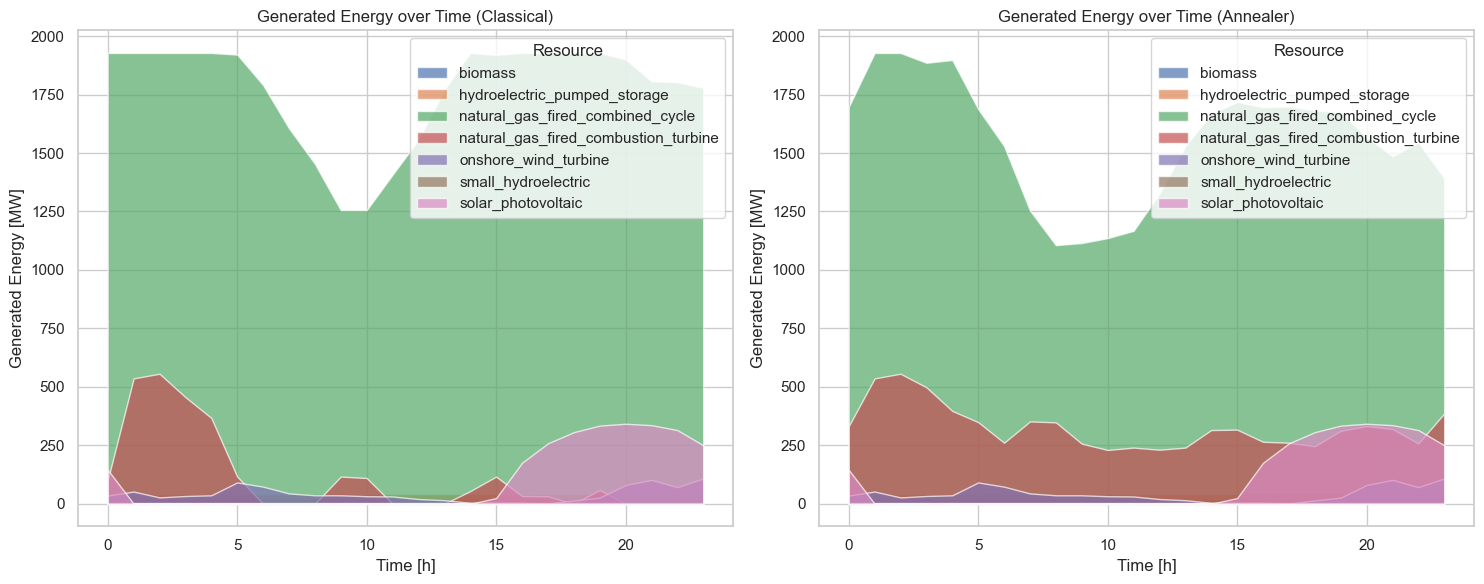

In [11]:
# Group size 576 data for classical and annealer results
grouped_size = results_no_start_shut.groupby('Problem size')
group_size_576 = grouped_size.get_group(600)

# Group by 'Generator' and 'Time', then sum the 'Energy' for each group for classical and annealer results
energy_classical = group_size_576.groupby(['Resources', 'Periods'])['Generated energy classical'].sum().reset_index()
energy_annealer = group_size_576.groupby(['Resources', 'Periods'])['Generated energy annealer'].sum().reset_index()

# Sort the DataFrames by the Resource and Time columns
energy_classical.sort_values(['Resources', 'Periods'], inplace=True)
energy_annealer.sort_values(['Resources', 'Periods'], inplace=True)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set(style="whitegrid")

# Plot for classical results
for resource, df_group in energy_classical.groupby('Resources'):
    axes[0].fill_between(df_group['Periods'], df_group['Generated energy classical'], label=resource, alpha=0.7)
axes[0].set_xlabel('Time [h]')
axes[0].set_ylabel('Generated Energy [MW]')
axes[0].set_title('Generated Energy over Time (Classical)')
axes[0].legend(title='Resource')

# Plot for annealer results
for resource, df_group in energy_annealer.groupby('Resources'):
    axes[1].fill_between(df_group['Periods'], df_group['Generated energy annealer'], label=resource, alpha=0.7)
axes[1].set_xlabel('Time [h]')
axes[1].set_ylabel('Generated Energy [MW]')
axes[1].set_title('Generated Energy over Time (Annealer)')
axes[1].legend(title='Resource')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

The energy generation patterns of the annealer and classical solver exhibit similar shapes, aligning with the generator capacities. Natural gas fired combined cycle generators contribute the most energy, while renewable resources contribute the least. However, subtle distinctions exist between natural gas fired combined cycle and combustion turbine generators. To determine the optimal solution, we'll compare the operational costs across various problem sizes.

### 5. Plot the operational cost 

Next, we'll chart the operational cost or objective function for both classical and quantum implementations across various problem sizes. These plots will encompass different constraint scenarios, including those with and without start-up and shut-down constraints.

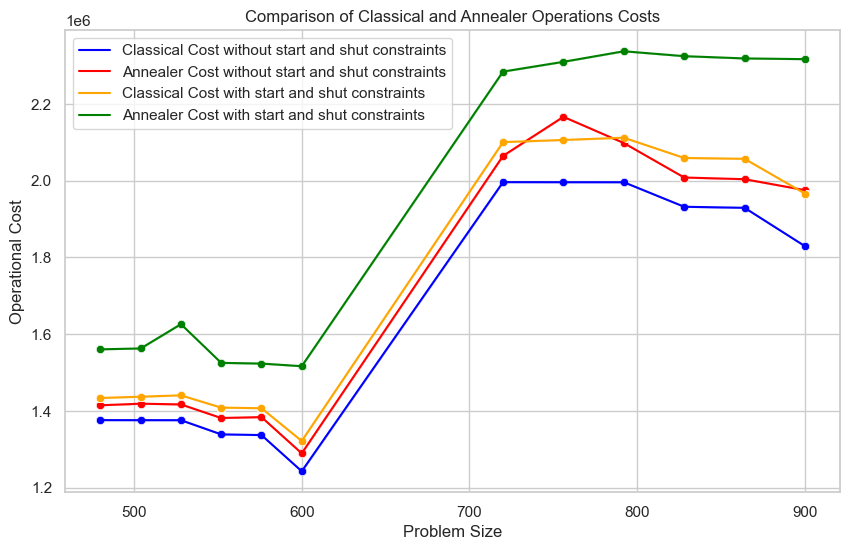

In [9]:
# Create a scatter plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Assuming 'size' is the column name for problem size and
# 'classical cost' and 'cost annealer' are the columns for costs
sns.scatterplot(data=results_no_start_shut, x='Problem size', y='Operational cost classical', color='blue')
sns.scatterplot(data=results_no_start_shut, x='Problem size', y='Operational cost annealer', color='red')

sns.lineplot(data=results_no_start_shut, x='Problem size', y='Operational cost classical', label='Classical Cost without start and shut constraints', color='blue')
sns.lineplot(data=results_no_start_shut, x='Problem size', y='Operational cost annealer', label='Annealer Cost without start and shut constraints', color='red')

# Assuming 'size' is the column name for problem size and
# 'classical cost' and 'cost annealer' are the columns for costs
sns.scatterplot(data=results_start_shut, x='Problem size', y='Operational cost classical', color='orange')
sns.scatterplot(data=results_start_shut, x='Problem size', y='Operational cost annealer', color='green')

sns.lineplot(data=results_start_shut, x='Problem size', y='Operational cost classical', label='Classical Cost with start and shut constraints', color='orange')
sns.lineplot(data=results_start_shut, x='Problem size', y='Operational cost annealer', label='Annealer Cost with start and shut constraints', color='green')

plt.xlabel('Problem Size')
plt.ylabel('Operational Cost')
plt.title('Comparison of Classical and Annealer Operations Costs')
plt.legend()
plt.show()

The graph reveals that both cases, with and without start-up and shut-down constraints, exhibit similar trends in operational costs. In both scenarios, the classical implementation outperforms the quantum annealer, as the aim is to minimize operational costs. This suggests that quantum hardware, while promising, is not yet mature enough to consistently achieve the optimal solution, assuming classical implementation attains the global minimum. Although differences are minor, continued quantum hardware advancements hold the potential to bridge this gap, enabling solutions to complex, classically intractable optimizations.

### 6. Plot the computational time

Now we will plot the computational time taken to perform these calculations against different problem sizes.

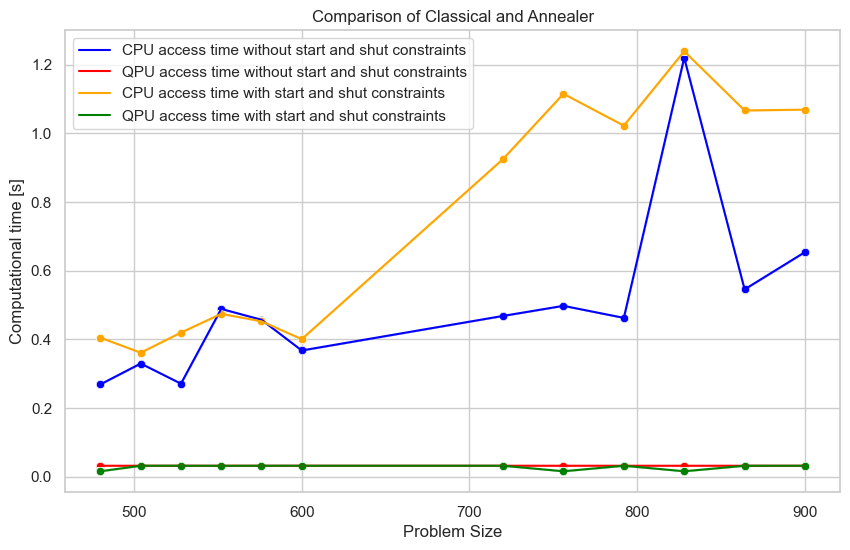

In [14]:
# Create a scatter plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Assuming 'size' is the column name for problem size and
# 'classical cost' and 'cost annealer' are the columns for costs
sns.scatterplot(data=results_no_start_shut, x='Problem size', y='CPU time', color='blue')
sns.scatterplot(data=results_no_start_shut, x='Problem size', y='QPU access time', color='red')

sns.lineplot(data=results_no_start_shut, x='Problem size', y='CPU time', label='CPU access time without start and shut constraints', color='blue')
sns.lineplot(data=results_no_start_shut, x='Problem size', y='QPU access time', label='QPU access time without start and shut constraints', color='red')

# Assuming 'size' is the column name for problem size and
# 'classical cost' and 'cost annealer' are the columns for costs
sns.scatterplot(data=results_start_shut, x='Problem size', y='CPU time', color='orange')
sns.scatterplot(data=results_start_shut, x='Problem size', y='QPU access time', color='green')

sns.lineplot(data=results_start_shut, x='Problem size', y='CPU time', label='CPU access time with start and shut constraints', color='orange')
sns.lineplot(data=results_start_shut, x='Problem size', y='QPU access time', label='QPU access time with start and shut constraints', color='green')

plt.xlabel('Problem Size')
plt.ylabel('Computational time [s]')
plt.title('Comparison of Classical and Annealer')
plt.legend()
plt.show()

The graph above reveals a consistent annealing time for the Quantum Processing Unit (QPU) across varying problem sizes. Conversely, the computational time for the classical implementation increases as the problem complexity grows, aligning with our expectations. Quantum annealing's relatively shorter time may stem from inherent parallelism in quantum systems, driven by quantum fluctuations, facilitating faster computations. Additionally, DWave imposes time limits on their annealer, varying by the problem's complexity. 

These findings raise intriguing questions: Given a constrained annealing time, which falls short of what classical methods require for optimal solutions, how effective can our quantum solution be? Furthermore, could extending the annealing time yield improved problem solutions?

### 7. Plot relative error

Lastly, we will chart the relative error of optimal decision variables obtained from the quantum and classical implementations, assuming the classical solution as the benchmark. This will be done across varying problem sizes, providing insights into the disparity between our quantum solution and the assumed correct one.

In [34]:
def calculate_relative_error(predicted_array, actual_array):
    """
    Calculate the relative error between two arrays of predicted and actual values.

    Parameters:
    predicted_array (numpy.ndarray): An array of predicted values.
    actual_array (numpy.ndarray): An array of actual (reference) values.

    Returns:
    float: The relative error between the predicted and actual values.
    """

    # Create a mask to filter out NaN values
    mask = ~np.isnan(predicted_array) & ~np.isnan(actual_array)

    # Apply the mask to both arrays
    predicted_array = predicted_array[mask]
    actual_array = actual_array[mask]
    
    # Calculate mean absolute error (MAE)
    mae = np.mean(np.abs(predicted_array - actual_array))

    # Calculate the mean value of the actual array
    mean_actual = np.mean(actual_array)

    # Calculate relative error
    relative_error = mae / mean_actual
    
    return relative_error

In [27]:
# Group by final_results size and calculate the mean of numeric columns
grouped = results_start_shut.groupby('Problem size')
rows_to_append = []

for group_name in grouped.groups.keys():
    group_df = grouped.get_group(group_name)

    new_row = {'Problem size': group_name, 'Relative error generated energy': calculate_relative_error(group_df['Generated energy annealer'].values, group_df['Generated energy classical'].values),
               'Relative error commit': calculate_relative_error(group_df['Commitment annealer'].values, group_df['Commitment classical'].values)}
    rows_to_append.append(new_row)

# Create the DataFrame from the list of dictionaries
relative_error = pd.DataFrame(rows_to_append)

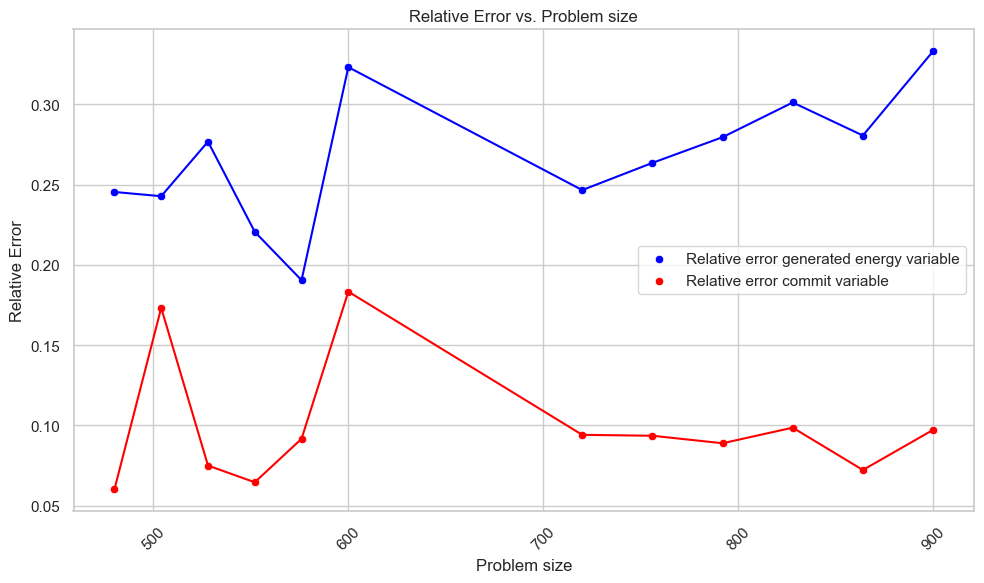

In [30]:
# Create a Seaborn plot
plt.figure(figsize=(10, 6))

sns.scatterplot(x='Problem size', y='Relative error generated energy', label ='Relative error generated energy variable', data=relative_error, color='blue')
sns.lineplot(x='Problem size', y='Relative error generated energy', data=relative_error, color='blue')

sns.scatterplot(x='Problem size', y='Relative error commit', label ='Relative error commit variable', data=relative_error, color='red')
sns.lineplot(x='Problem size', y='Relative error commit', data=relative_error, color='red')

plt.xlabel('Problem size')
plt.ylabel('Relative Error')
plt.title('Relative Error vs. Problem size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The relative error analysis indicates that, as problem complexity increases, the quantum annealer consistently exhibits a consistent level of error. Notably, the relative error is relatively higher for the generation variable, ranging from nearly 20% to 30%, compared to the commit variable, which ranges from around 6% to 18%. This difference may arise from the inherently discrete nature of binary variables, such as 'commit,' which allow for less margin of error compared to integer variables like 'generated energy.' These findings underscore the current limitations of quantum hardware in achieving optimal solutions and highlight the need for further advancements in quantum computing for more accurate results.

### 8. Conclusions


- Quantum annealing and classical methods produce similar energy generation patterns.
- Operational cost evolution is similar for both quantum and classical methods.
- Classical implementation generally yields more optimal solutions, indicating quantum hardware's current limitations.
- Benchmarking across different problem sizes reveals the scalability of quantum and classical implementations.
- As problems become more complex, quantum annealing time remains constant, while classical time increases as expected. Quantum annealing's efficiency may be attributed to inherent quantum parallelism and time limitations on quantum annealers.
- Relative error remains consistent with increasing problem complexity in quantum annealing.
- Quantum hardware's current maturity level affects its ability to achieve optimal solutions.